<a href="https://www.kaggle.com/code/parisammm/lstm-model-for-time-series-forcasting?scriptVersionId=158741707" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('/kaggle/input/amozon/Amazon Stock.csv')


/kaggle/input/amozon/Amazon Stock.csv


In [2]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


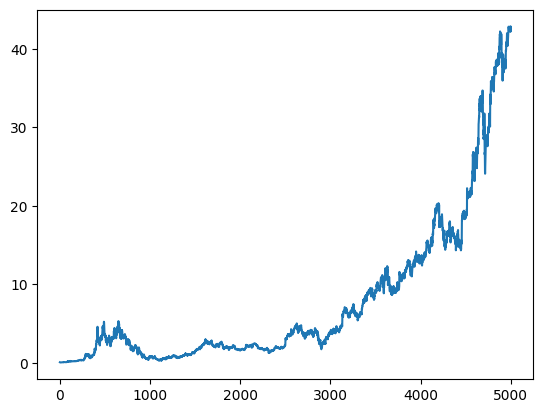

In [3]:
timeseries = df['Close'][0:5000].values.astype('float32')
plt.plot(timeseries)

In [4]:
data = df['Close'][0:5000].values.reshape(-1,1)

In [5]:
data

array([[ 0.097917],
       [ 0.086458],
       [ 0.085417],
       ...,
       [42.280499],
       [42.341   ],
       [42.799999]])

> Normalize the data

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
Scaled_data = scaler.fit_transform(data)

In [7]:
train_set = Scaled_data[:4000,:]
test_set = Scaled_data[4000:,:]

> <span style="font-family:Comic Sans MS"><span style="font-size:2em">Prepare sequences for training</span>

In [8]:
sequence_length = 10
sequences = []
for i in range(len(train_set) - sequence_length):
    sequences.append(train_set[i: i+sequence_length + 1])
sequences = np.array(sequences)

In [9]:
sequences_test = []
for i in range(len(test_set) - sequence_length):
    sequences_test.append(test_set[i: i+sequence_length + 1])
sequences_test = np.array(sequences_test)

In [10]:
x = sequences[:, :-1]  # Input sequences
y = sequences[:, -1]   # Labels

> <span style="font-family:Comic Sans MS"><span style="font-size:2em">Convert data to PyTorch tensors</span>

In [11]:
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

x_test = torch.from_numpy(sequences_test[:, :-1]).float()

> <span style="font-family:Comic Sans MS"><span style="font-size:2em">Create DataLoader for batch processing</span>

In [12]:
batch_size = 64
train_dataset = TensorDataset(x_train, y_train,)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# <span style="font-family:Comic Sans MS"><span style="font-size:2em">Define the LSTM model</span>

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out)

        return predictions[:,-1,:]


> <span style="font-family:Comic Sans MS"><span style="font-size:2em">initialze model</span>

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_size=1
hidden_size=50
output_size=1
model = LSTM(input_size, hidden_size, output_size).to(device)

In [15]:
model

LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

> <span style="font-family:Comic Sans MS"><span style="font-size:2em">Define loss function and optimizer</span>

In [16]:
lr = 0.01
epochs=2

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# <span style="font-family:Comic Sans MS"><span style="font-size:2em">Training</span> 

In [18]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/2], Loss: 0.0032
Epoch [2/2], Loss: 0.0000


# <span style="font-family:Comic Sans MS"><span style="font-size:2em">predicted plot vs the orginal dataset </span>

In [19]:
y_preds= model(x_train.to(device))
#give item for each tensor in a list of tensors and then convert to a array
y_preds = np.array([tensor.item() for tensor in y_preds])

In [20]:
y_preds_test= model(x_test.to(device))
y_preds_test = np.array([tensor.item() for tensor in y_preds_test])

In [21]:
inverse_y_preds = scaler.inverse_transform(y_preds.reshape(-1,1))
inverse_y_preds_test = scaler.inverse_transform(y_preds_test.reshape(-1,1))

In [22]:
len(train_set)

4000

In [23]:
len(inverse_y_preds)

3990

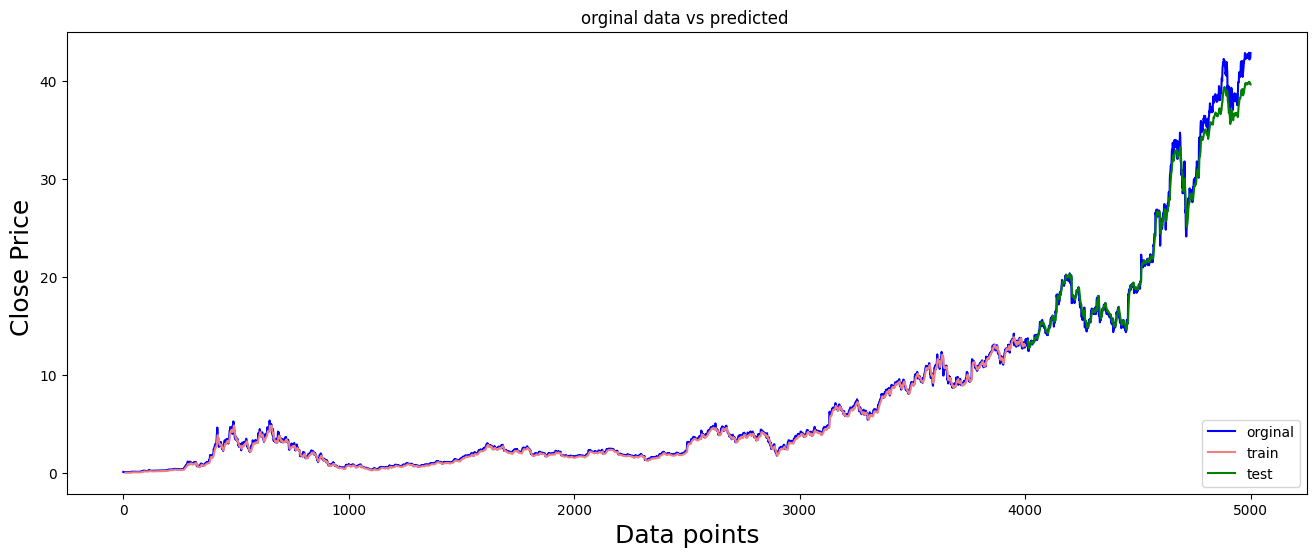

In [24]:
# shift train predictions for plotting
train_plot = np.ones_like(timeseries) * np.nan
train_plot[sequence_length:len(train_set)] = inverse_y_preds.flatten()

test_plot = np.ones_like(timeseries) * np.nan
test_plot[(4000+sequence_length):] = inverse_y_preds_test.flatten()

# plot
plt.figure(figsize=(16,6))
plt.plot(data.flatten(), c='b')
plt.plot(train_plot, c='lightcoral')
plt.plot(test_plot, c='g')
plt.title('orginal data vs predicted ')
plt.xlabel('Data points', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.legend(['orginal', 'train', 'test'], loc='lower right')
plt.show()